# Simulator Response Comparison

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from numba import jit

%matplotlib inline

In [2]:
# Assumes times are ordered
@jit(nopython=True)
def get_ISIs(ids, times, num_neurons=3200):
    ISIs = np.empty((np.sum(ids < num_neurons)))
    currentloc = 0
    num_responsive_neurons = 0
    for n in range(num_neurons):
        indv_neuronspikes = np.sort(times[ids == n])
        numiterate = len(indv_neuronspikes) - 1
        if (numiterate > 0):
            num_responsive_neurons += 1
            difference = indv_neuronspikes[1:] - indv_neuronspikes[0:-1]
            ISIs[currentloc:(currentloc + numiterate)] = difference
            currentloc += numiterate
    return (ISIs[:-num_responsive_neurons])

def get_rates(ids, times, num_neurons=3200, starttime=0.0, endtime=100.0):
    neuronrates = np.empty(num_neurons)
    mask = times > starttime
    for n in range(num_neurons):
        num_spikes = np.sum(ids[mask] == (n))
        neuronrates[n] = num_spikes / (endtime - starttime)
    return (neuronrates)

### Loading Auryn firing times

In [3]:
ls ../auryn/

Build/        coba.0.i.ras       Makefile                timefile.dat
coba.0.e.ras  coba_e_merged.ras  sim_coba_benchmark.cpp


In [4]:
auryn_df = pd.read_csv("../auryn/coba.0.e.ras", delim_whitespace=True, header=None, names=["times", "ids"])

In [5]:
# Calculate ISIs
auryn_ISIs = get_ISIs(auryn_df["ids"].values, auryn_df["times"].values)
# Calculating firing rates for the last 50s
auryn_neuronrates = get_rates(auryn_df["ids"].values, auryn_df["times"].values)

In [6]:
auryn_data = {
    "name": "Auryn",
    "spikes": auryn_df,
    "ISIs": auryn_ISIs,
    "rates": auryn_neuronrates
}

In [7]:
np.mean(auryn_neuronrates)

17.354084374999999

### Loading Nest firing times

In [8]:
ls ../pyNest/

Build/  COBA.py  setpaths.sh*  timefile.dat  va-py-ex-4001-0.gdf


In [9]:
nest_df = pd.read_csv("../pyNest/va-py-ex-4001-0.gdf", delim_whitespace=True, header=None, names=["ids", "times"])

In [10]:
# Bring nest timing into seconds
nest_df["times"] /= 1000.0

In [11]:
# Calculate ISIs
nest_ISIs = get_ISIs(nest_df["ids"].values - 1, nest_df["times"].values)
# Calculating firing rates for the last 50s
nest_neuronrates = get_rates(nest_df["ids"].values - 1, nest_df["times"].values)

In [12]:
nest_data = {
    "name": "Nest",
    "spikes": nest_df,
    "ISIs": nest_ISIs,
    "rates": nest_neuronrates
}

In [13]:
np.mean(nest_neuronrates)

17.099081249999998

### Loading Spike firing times

In [14]:
ls ../Spike/Build/

CMakeCache.txt  cmake_install.cmake  timefile.dat    VASpikeTimes.bin
CMakeFiles/     Makefile             VASpikeIDs.bin  VogelsAbbottNet*


In [15]:
idsfile = "../Spike/Build/VASpikeIDs.bin"
timesfile = "../Spike/Build/VASpikeTimes.bin"
spike_df = pd.DataFrame(data = {"ids": np.fromfile(idsfile, dtype=np.int32), "times": np.fromfile(timesfile, dtype=np.float32)})


In [16]:
# Calculate ISIs
spike_ISIs = get_ISIs(spike_df["ids"].values, spike_df["times"].values)
# Calculating firing rates for the last 50s
spike_neuronrates = get_rates(spike_df["ids"].values, spike_df["times"].values)

In [17]:
spike_data = {
    "name": "Spike",
    "spikes": spike_df,
    "ISIs": spike_ISIs,
    "rates": spike_neuronrates
}

In [18]:
np.mean(spike_neuronrates)

17.453899999999997

### Loading ANNarchy firing times

In [19]:
ls ../ANNarchy/

annarchy/  COBA.py  spikes.out  timefile.dat


In [20]:
spikesfile = "../ANNarchy/spikes.out"
annarchy_df = pd.read_csv(spikesfile, delim_whitespace=True, header=None, names=["ids", "times"])

In [21]:
# Bring ANNarchy timing into seconds
annarchy_df["times"] /= 10000.0

In [22]:
# Calculate ISIs
annarchy_ISIs = get_ISIs(annarchy_df["ids"].values, annarchy_df["times"].values)
# Calculating firing rates for the last 50s
annarchy_neuronrates = get_rates(annarchy_df["ids"].values, annarchy_df["times"].values)

In [23]:
annarchy_data = {
    "name": "ANNarchy",
    "spikes": annarchy_df,
    "ISIs": annarchy_ISIs,
    "rates": annarchy_neuronrates
}

In [24]:
np.mean(annarchy_neuronrates)

17.194906249999999

### Loading Brian2 firing times

In [45]:
ls ../brian2/

COBA.py  spikes.out  timefile.dat


In [46]:
spikesfile = "../brian2/spikes.out"
brian2_df = pd.read_csv(spikesfile, delim_whitespace=True, header=None, names=["ids", "times"])

In [47]:
# Calculate ISIs
brian2_ISIs = get_ISIs(brian2_df["ids"].values, brian2_df["times"].values)
# Calculating firing rates for the last 50s
brian2_neuronrates = get_rates(brian2_df["ids"].values, brian2_df["times"].values)

In [48]:
brian2_data = {
    "name": "Brian2",
    "spikes": brian2_df,
    "ISIs": brian2_ISIs,
    "rates": brian2_neuronrates
}

In [49]:
np.mean(brian2_neuronrates)

23.88285625

### Loading GeNN firing times

In [30]:
ls ../genn/

generateALL*  parameters.h  simulator_wrapper*    timer.h
lif.h         simulator*    sm_version.mk         va_benchmark_CODE/
Makefile      simulator.cc  spike_csv_recorder.h
matLoader.h   simulator.d   spikes.csv
model.cc      simulator.o   timefile.dat


In [36]:
spikesfile = "../genn/spikes.csv"
genn_df = pd.read_csv(spikesfile)
genn_df = genn_df.rename(index=str, columns={" Neuron ID": "ids", "Time [ms]": "times"})

In [37]:
# Bring timing into seconds
genn_df["times"] /= 10000.0

In [38]:
# Calculate ISIs
genn_ISIs = get_ISIs(genn_df["ids"].values, genn_df["times"].values)
# Calculating firing rates for the last 50s
genn_neuronrates = get_rates(genn_df["ids"].values, genn_df["times"].values)

In [39]:
genn_data = {
    "name": "GeNN",
    "spikes": genn_df,
    "ISIs": genn_ISIs,
    "rates": genn_neuronrates
}

In [40]:
np.mean(genn_neuronrates)

17.052209375

## Comparing Simulators

In [53]:
simulator_data = [
    nest_data,
    spike_data,
    auryn_data,
    annarchy_data,
    brian2_data,
    genn_data
]

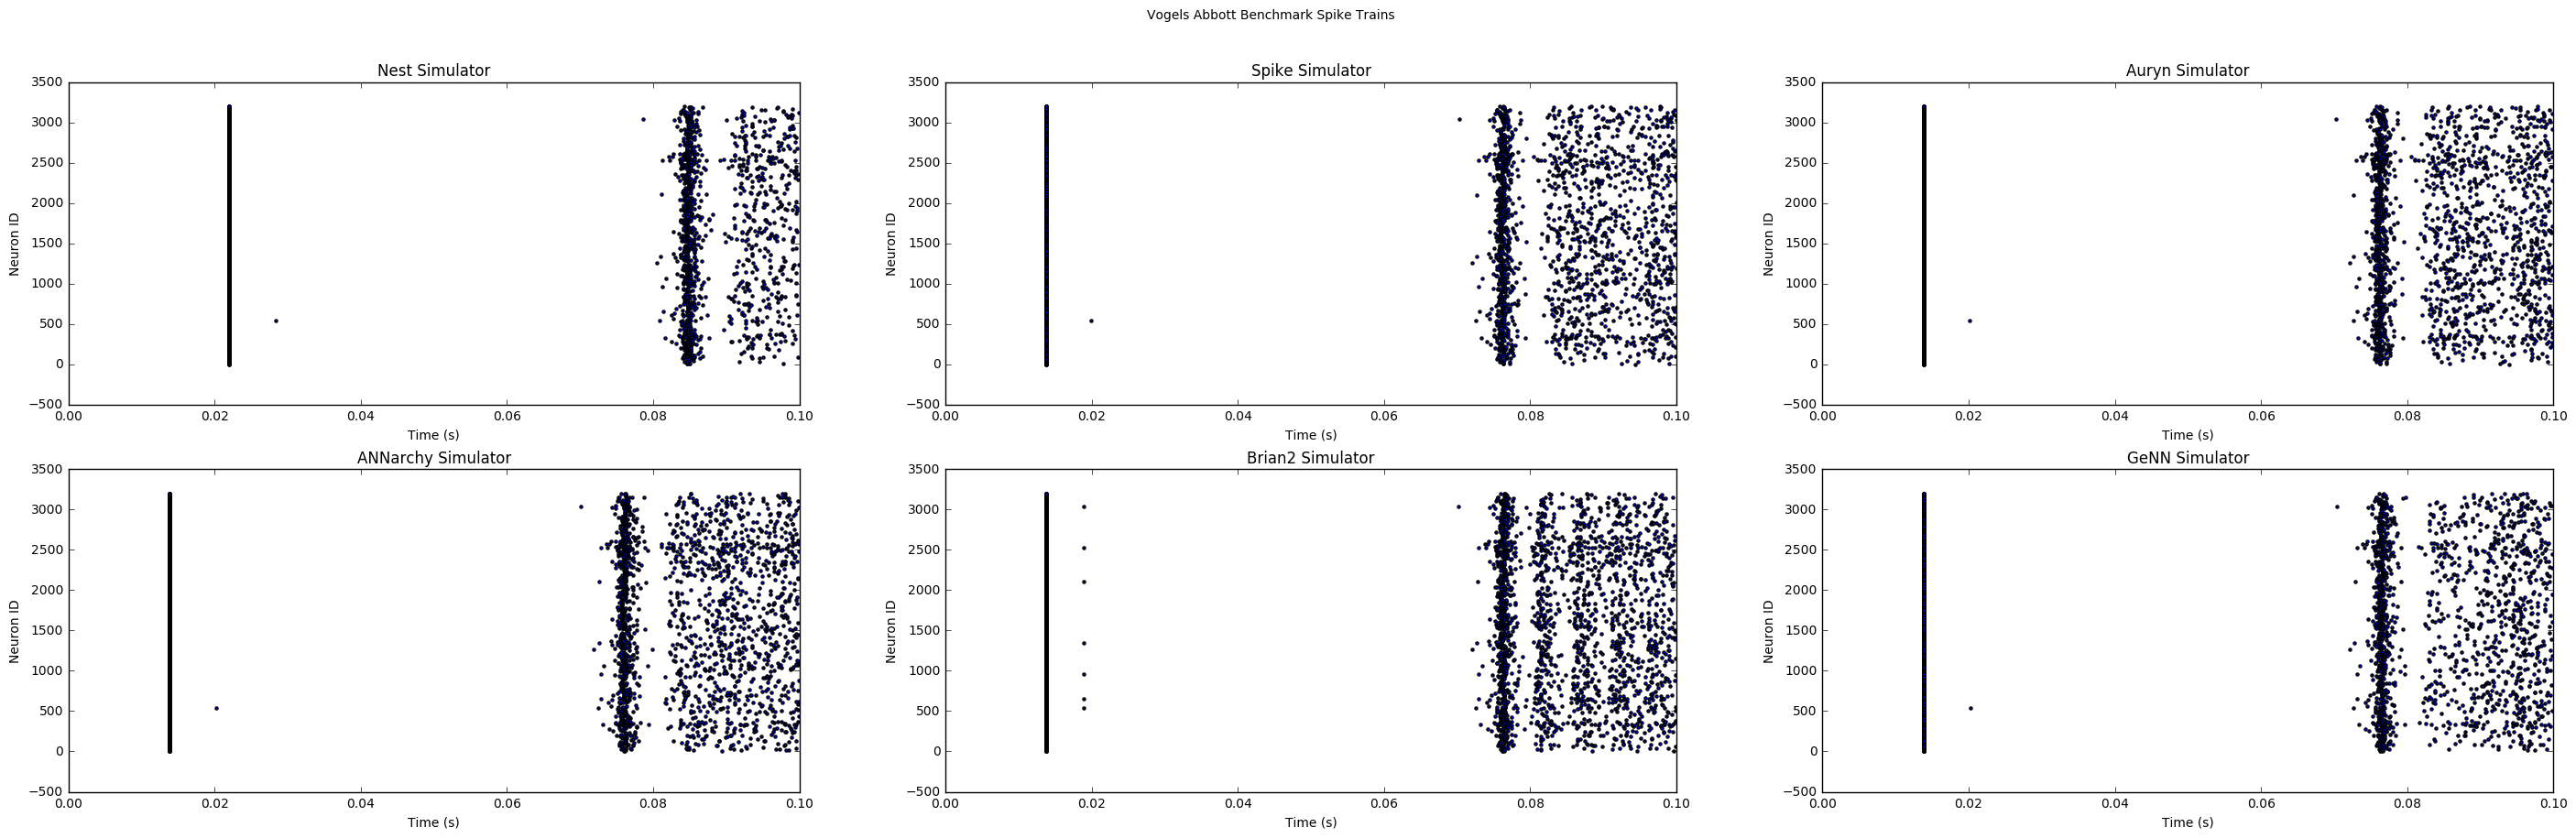

In [54]:
fig = plt.figure(figsize=(35, 10))
starttime = 0.0
endtime = 0.1

for index, data in enumerate(simulator_data):
    ax = plt.subplot(2, len(simulator_data) / 2, index + 1)
    mask = (data["spikes"]["times"] > starttime) & (data["spikes"]["times"] < endtime) & (data["spikes"]["ids"] < 3200)
    ax.scatter(data["spikes"]["times"][mask], data["spikes"]["ids"][mask], marker='.')
    ax.set_title(data["name"] + " Simulator")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Neuron ID")
    ax.set_xlim([starttime, endtime])

fig.suptitle('Vogels Abbott Benchmark Spike Trains')

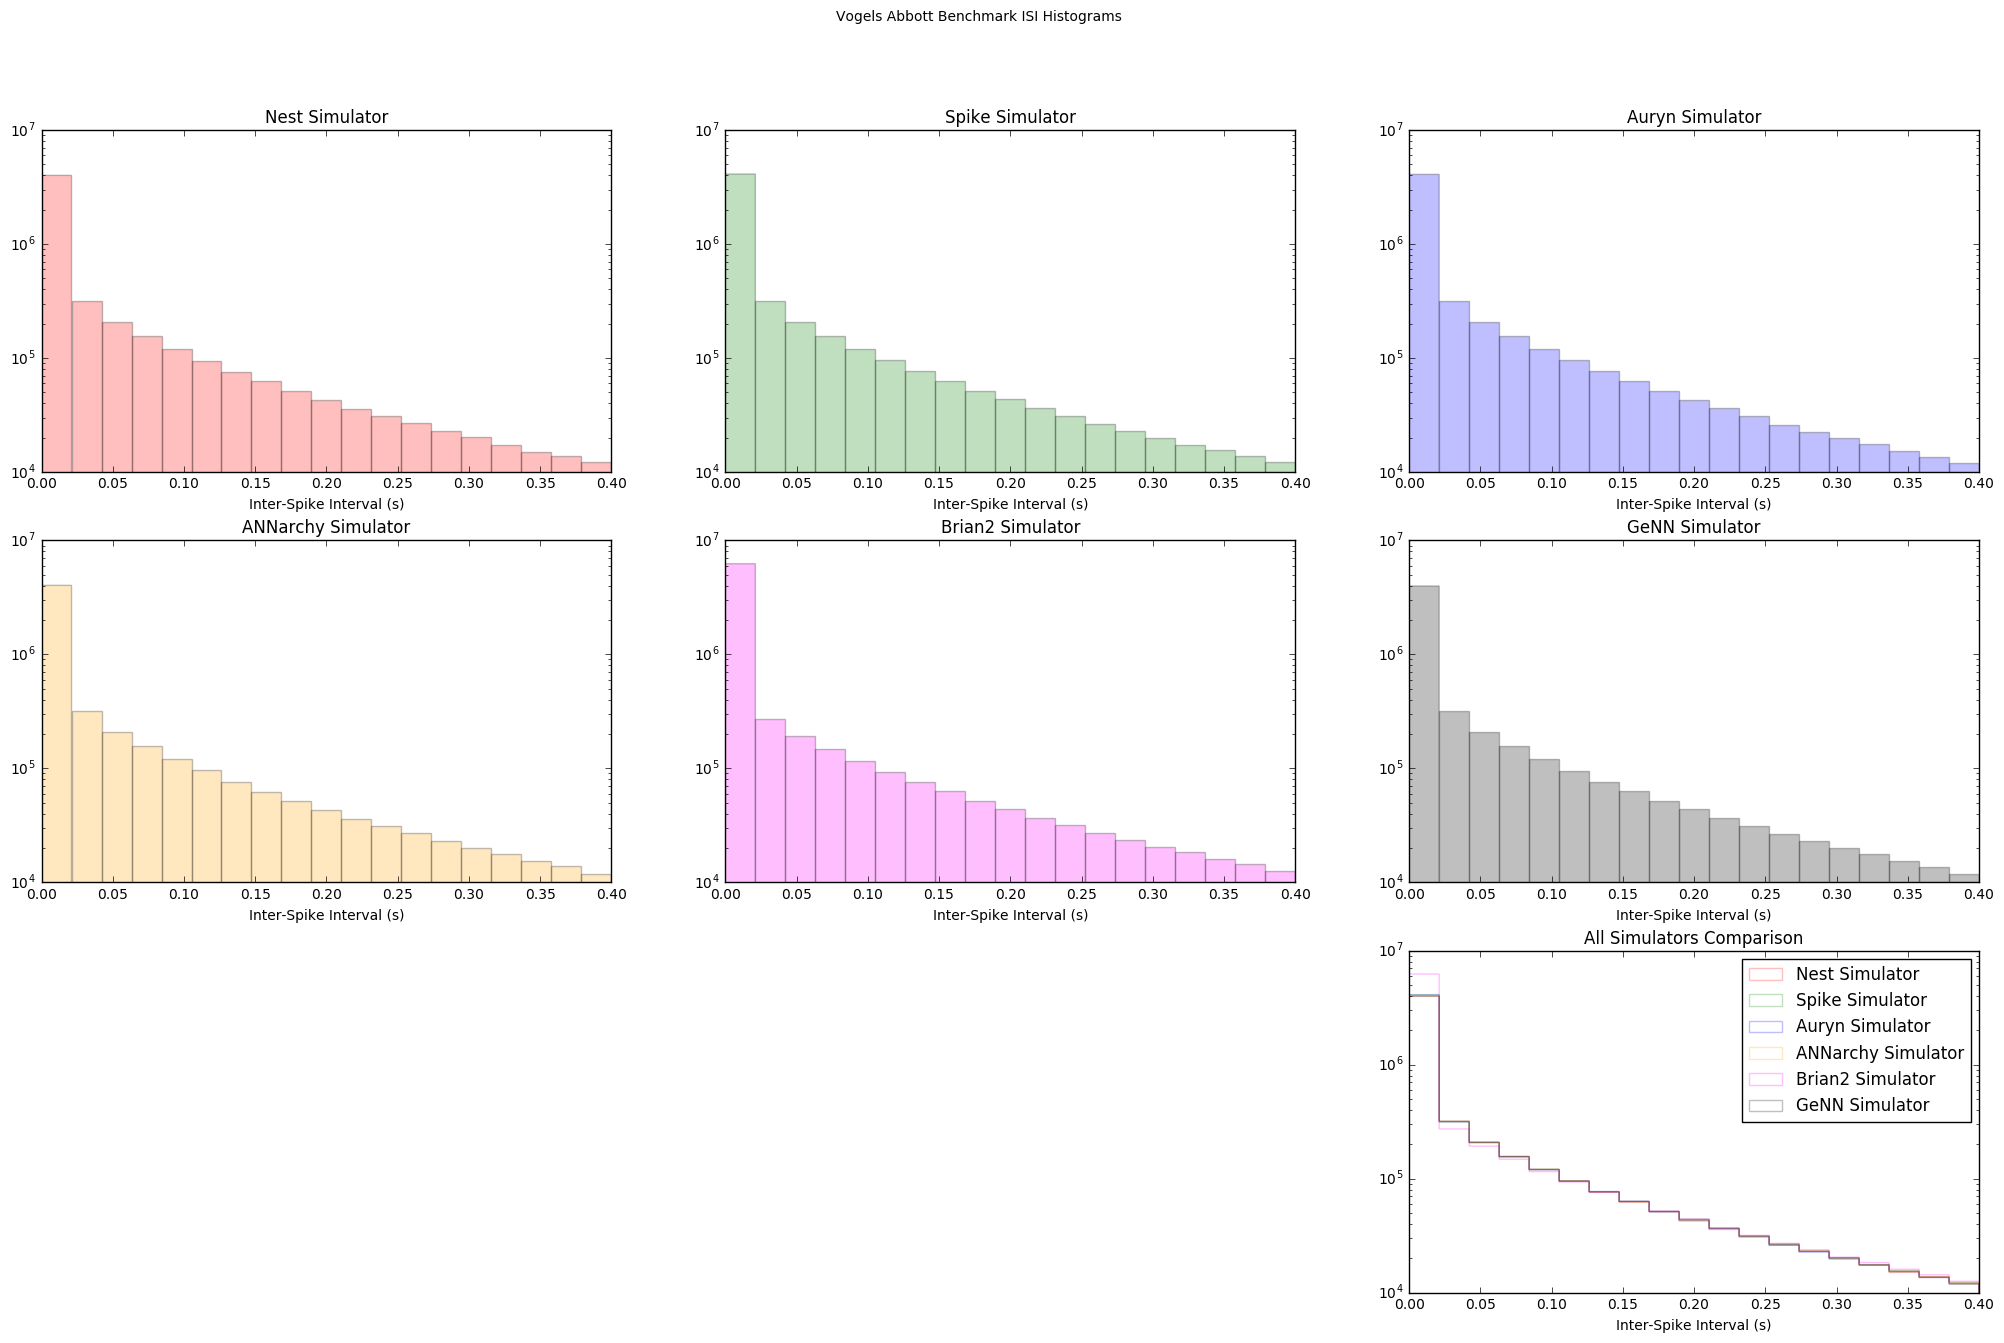

In [55]:
binvals = np.linspace(0.0, 0.4, 20)
colours = ['red', 'green', 'blue', 'orange', 'magenta', 'black']
fig = plt.figure(figsize=(25, 15))
num_rows = 3

#Individual ISI plots
for index, data in enumerate(simulator_data):
    ax = plt.subplot(num_rows, int(np.ceil(float(len(simulator_data) + 1) / num_rows)), index + 1)
    ax.set_yscale('log')
    ax.hist(np.asarray(data["ISIs"]), bins=binvals, label=(data["name"] + " Simulator"), alpha=0.25, color=colours[index])
    ax.set_title(data["name"] + " Simulator")
    ax.set_xlabel("Inter-Spike Interval (s)")
    ax.set_xlim([0.00, 0.40])
    ax.set_ylim([10**4, 10**7])


# Combined ISI plot
all_ax = plt.subplot(num_rows, int(np.ceil(float(len(simulator_data) + 1) / num_rows)), (num_rows * int(np.ceil(float(len(simulator_data) + 1) / num_rows))))
for index, data in enumerate(simulator_data):
    all_ax.hist(np.asarray(data["ISIs"]), bins=binvals, label=(data["name"] + " Simulator"), alpha=0.25, color=colours[index], histtype=u'step')
all_ax.set_title("All Simulators Comparison")
all_ax.set_xlabel("Inter-Spike Interval (s)")
all_ax.set_yscale('log')
all_ax.set_ylim([10**4, 10**7])
all_ax.set_xlim([0.00, 0.40])
all_ax.legend()

fig.suptitle('Vogels Abbott Benchmark ISI Histograms')

In the plots above, note that the simulators have close to identical ISI distributions except for Brian2

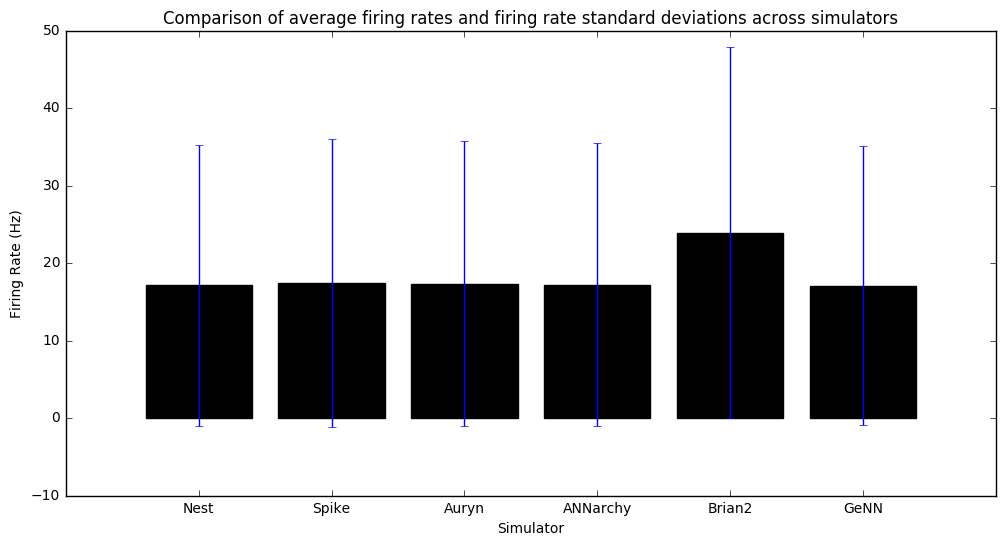

In [56]:
fig = plt.figure(figsize=(12, 6))

meanrates = []
ratestd = []
labelstrings = []

for index, data in enumerate(simulator_data):
    meanrates.append(np.mean(data["rates"]))
    ratestd.append(np.std(data["rates"]))
    labelstrings.append(data["name"])

plt.bar(range(len(simulator_data)), meanrates, yerr=ratestd, color="k", align='center')
plt.xticks(range(len(simulator_data)), labelstrings)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Simulator")
plt.title("Comparison of average firing rates and firing rate standard deviations across simulators")